# Anomaly Detection

In this notebook we finally perform our anomaly detection. We perform this in 6 steps:
1. Create a data frame for each individual username showing authentication types for 8/24 hours of each day
2. Use EDA, Isolation Forest's, Local Outlier Factor and other models to find 'normal' days or 'normal' usernames to allow us to train th CP_APR model
3. Train the CP_APR model with the data we've identified in step 2
4. Run the trained CP_APR model on the other data to identify anomalies in the 'test' data
5. Use a function to return the anomalous entry from the original data frame based on the output of the CP_APR function
6. Create a new data frame of anomalies

Finally, we may verify this process through other means such as HTM studio for a subset or other anomaly detection techniques. We may also use the original red team authentication data to determine whether the events given there were picked up by the CP_APR method.

First we import our libraries that we need.

In [1]:
from pyCP_APR import CP_APR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path
import gzip
import shutil
import datetime
import networkx as nx
import pickle
from scipy import stats
from scipy import sparse
import bz2
import random
random.seed(1134)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

from IPython.display import clear_output

### Original Data

Now we import the original data.

In [2]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('../Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('../Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0

    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)

    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [72]:
authentication_data[authentication_data['UserName'] == 'User035855']

,UserName,SrcDevice,DstDevice,Authent Type,Failure,DailyCount
0,User035855,Comp808475,Comp081330,TGS,0,17.0
6003,User035855,Comp808475,Comp081330,NetworkLogon,0,177.0
7915,User035855,Comp808475,Comp370444,NetworkLogon,0,11.0
20590,User035855,Comp808475,ActiveDirectory,NetworkLogon,0,105.0
21655,User035855,Comp808475,Comp004340,TGS,0,1.0
...,...,...,...,...,...,...
126274,User035855,Comp808475,ActiveDirectory,TGS,0,31.0
133464,User035855,Comp808475,Comp808475,TGS,0,7.0
138213,User035855,Comp808475,Comp253429,TGS,0,1.0
140361,User035855,Comp808475,Comp546675,TGS,0,2.0


### Other required data

#### Possible Username Lists

We need a list of usernames we'll consider for training/testing. Currently at the beginning of all this we will consider all usernames for both training and testing and reduce this as we go.

In [3]:
train_users = list(authentication_data['UserName'].unique())
test_users = list(authentication_data['UserName'].unique())

In [4]:
len(train_users)

28815

#### Authentication Red Team Usernames

In [5]:
rt_usernames = list(pd.read_csv('../Data/AuthUserNames.txt', header=None)[0])

#### Authentication Types

We'll need a dictionary of authentication types for later use.

In [6]:
a_t = list(authentication_data['Authent Type'].unique())
AT_dict = { i : a_t[i] for i in range(0, len(a_t) ) }

#### Authentication Day Starts

The below code defines the indices where each day begins in the authentiation data.

In [7]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

### Step 1: DataFrame Creation

This first function is used to split a data frame into equal chunks. Since we need to split each day into 8/24 hours we use this function to split into equal time periods - this may not be perfectly representitive of the actual hour split but should be a good estimate since we don't have the original time stamps.

In [8]:
def split_dataframe(df,n): 
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

This function creates the required data frames. It takes as input a username and a split by number (8/24) and returns a data frame of the user's authentiation events split by type over 90 days, split by 8/24 hours.

In [9]:
def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type').size()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

This function creates the inputs for our CP_APR model. We pass a list of usernames to the function and it returns the set of co-ordinate tuples (i,j,e) where we have non-zero entries in our data matrices, along with the corresponding values for that matrix. i is the row of the matrix i.e. time, j is the column i.e. authentication type and e is the username number. We can instead pass a single username which would return this for just one user but this is optimised to run for all users when required.

In [10]:
# def sparse_df(usernamelist,n):
    
#     coords = []
#     vals_list = []
    
#     for e,user in enumerate(usernamelist):
#         df = auth_type_un_df(user,n)
    
#         s = sparse.coo_matrix(df)
#         co = [[s.row[i],s.col[i],e] for i in range(len(s.row))]
#         vals = s.data
        
#         coords.append(co)
#         vals_list.append(vals)
    
#     coords = np.array([item for sublist in coords for item in sublist])
#     vals_list = np.array([item for sublist in vals_list for item in sublist])
    
#     return vals_list, coords

# the function above does this for a list of usernames - doesn't work atm so needs fixing but the below does what we want for a single username
def sparse_df(username,n):
    
    df = auth_type_un_df(username,n)

    s = sparse.coo_matrix(df)
    co = [[s.row[i],s.col[i],1] for i in range(len(s.row))]
    vals = s.data
    
    return vals, co

In [11]:
# stime = datetime.datetime.now()

# n=10
# for i in range(n):
#     vals,co = sparse_df(train_users[i],24)

# etime = datetime.datetime.now()

# print('Time taken for {} iterations: {}.'.format(n,etime-stime))

In [12]:
# stime = datetime.datetime.now()

# n=10
# for i in range(n):
#     vals,co = sparse_df(train_users[i],24)

# etime = datetime.datetime.now()

# print('Time taken for {} iterations: {}.'.format(n,etime-stime))

So we take roughly 4 seconds to compute a single username - doing this for 28,815 usernames would take $28,815 * \frac{4}{86400} = 1.3 $ days. Lets rewrite this with parallelisation.

In [13]:
#%run -i SparseDataFrameCreation.py 10

In [14]:
#%run -i SparseDataFrameCreation.py 100

We see speed improvements for large numbers of usernames but not for small ones.

#### Examples

In [15]:
# Below is an example of a full matrix of the data we're considering called on a single username over 24 hours
#auth_type_un_df(train_users[0],24)

From the above we see that we obtain a data set of each day split into 24 hours. Each column represents an authentication type and non-zero entries represent an authentication event in that time period.

In [16]:
# Below is an example of the sparse matrix representation we'll pass to the model - creates a big list so is commented but feel free to uncomment
# sparse_df(train_users[1000],24)

The first list is the non-zero values in the matrix and the second list is the list of co-ordinates where those non-zero values occur.

### Step 2: Determining Training Data

Days 1-56, and 83-90 are normal activity and therefore are training data whereas days 57-82 contain red team data.

In [17]:
def scaled_iso_lof(data,plot=False,c='auto'):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # isolation forest predictions
    if_model = IsolationForest(contamination=c)
    if_predictions = if_model.fit_predict(data)
    
    # local outlier factor predictions
    lof = LocalOutlierFactor(n_neighbors=2)
    lof_predictions = lof.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_if = auth_types_pcapca.loc[if_predictions == -1]
        a_lof = auth_types_pca.loc[lof_predictions == -1]
        
        anomalies = auth_types_pca.loc[list(set(a_lof.index) & set(a_if.index))]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of combined anomalies found: {}. \n Number of LOF anomalies found: {}. \n Number of IF anomalies found: {}.'.format(len(anomalies), len(a_lof), len(a_if))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_if = data.loc[if_predictions == -1]
        a_lof = data.loc[lof_predictions == -1]

        anomalies = data.loc[list(set(a_lof.index) & set(a_if.index))]
    
    return anomalies

In [18]:
#%run -i ParallelisedTrainingData.py 22815

### Step 3: Train the CP_APR model

Here we define our CP_APR model. We then train it on the data we have determined to be 'normal' above to teach the model what is likely to be normal activity in the authentication sense.

In [19]:
cp_apr = CP_APR(n_iters=10, random_state=42, verbose=200, method='numpy', return_type='numpy')

In [20]:
#factors = cp_apr.fit(coords=train_coords, values=train_vals)
#factors

### Step 4: Apply the CP_APR model to the actual data

Here we apply the model to the data we want to find anomalies in. This data will then be used to find the final set of anomalies to pass into the final stage of our project.

In [21]:
#p_values = cp_apr.predict_scores(coords=test_coords, values=test_vals)
#p_values

### Step 5: Obtain the data frame of anomalies

Here we use the p-values found above to retrieve the final set of anomalies from the original data frame.

This function returns a single anomaly based on the test coordinates array we obtain i.e. the actual data we look for anomalies in, the entry value i.e. the position of the anomaly in the array output by our CP_APR model and n, the number of hours we split the data frame by.

In [22]:
def orig_finder(test_coords, entry_val, n):
    
    # gets the co-ordinates of the entry where we have the erro
    orig_co = test_coords[entry_val]
    
    # gets the authentication type
    authent = AT_dict[orig_co[1]]
    
    # gets the username of the individual who the anomaly occured with
    username = test_users[orig_co[2]]
    
    # gets the day the anomaly occured (n is the number of hours we split the data frame into)
    day = int(orig_co[0]/n)
    
    # gets the hour the anomaly occured in
    hour = orig_co[0] - n * day
    
    # gets the n hour chunks for that day
    chunks = split_dataframe(authentication_data[auth_start_days[day]:auth_start_days[day+1]],n)
    
    # gets the hour
    data = chunks[hour]
    
    # finds the anomaly
    anom = data[(data['UserName'] == username) & (data['Authent Type'] == authent)]
    
    return anom

The p-values array defined below will be the output of the CP_APR function. We then set a threshold for anomaly scores to determine what we will class as an anomaly. Using the np.where function we will find all instances where we are below the threshold and return a data frame of the anomalies that we have found.

In [23]:
#frames = []
#threshold = 0.05

#for i in range(len(np.where(p_values < threshold)[0])):
#    entry = np.where(p_values < threshold)[0][i]
#    anom = orig_finder(test_coords, entry_val, 24)
#    frames.append(anom)
    
#anomalies = pd.concat(frames)

#### Examples

In [24]:
# we find the first entry of the first day, where the Authentication type is TGS, for the 1000th user in the list of test_users
orig_finder([[0,0,1000]],0,24)

,UserName,SrcDevice,DstDevice,Authent Type,Failure,DailyCount
1105,User142760,Comp636379,Comp788417,TGS,0,11.0


Dan's Notes:
- Possibly hard to work with a single machine since it may change role
- Consider with computers, both source and destination computers
- Natural extension is to throw more information at the prediction - features et
- Plot p-values distribution (assume uniform) q-q plot (should see a gap and then you can set a threshold on them)
- Counts over time, days of the week structure
- Dismiss Saturdays/Sundays

### Auto Encoders

In [235]:
def feature_generation(user,n):
    
    df = pd.DataFrame(index = ['SrcUnique','DstUnique','Authentications','Failures'])
    n = n
    feat_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
    
    df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [236]:
df = feature_generation(rt_usernames[0],24)

In [237]:
import tensorflow as tf
import keras

In [238]:
# authentication type data frames - didn't seem to work particularly well
#df = auth_type_un_df(rt_usernames[0],24)
#df = df.drop('ScreensaverDismissed',axis=1)

In [243]:
TIME_STEPS = 4

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df[:24*57])
x_test = create_sequences(df[24*57:])
print("Training input shape: ", x_train.shape)

Training input shape:  (1365, 4, 4)


In [244]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [245]:
input_l = layers.Input(shape=(x_train.shape[1], x_train.shape[2],1))
x = layers.Conv2D(filters=32, kernel_size=7, padding="same",  activation="relu")(input_l)
x = layers.Dropout(rate=0.2)(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=7, padding="same",  activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


x = layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="relu")(encoded)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="relu")(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

convo_autoencoder = Model(input_l, decoded)
convo_autoencoder.compile(metrics=['accuracy'], optimizer='adam', loss='mse')

In [246]:
convo_autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 4, 4, 1)]         0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 4, 4, 32)          1600      
_________________________________________________________________
dropout_31 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 2, 2, 16)          25104     
_________________________________________________________________
dropout_32 (Dropout)         (None, 2, 2, 16)          0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 1, 1, 16)          0  

In [247]:
from tqdm.keras import TqdmCallback

In [248]:
history = convo_autoencoder.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
        TqdmCallback(verbose=1)
    ],)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

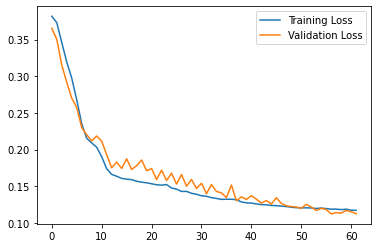

In [249]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

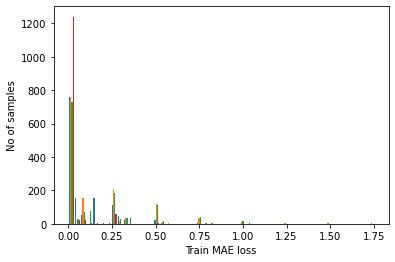

In [250]:
x_train_pred = convo_autoencoder.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred.reshape(x_train_pred.shape[0],x_train_pred.shape[1],x_train_pred.shape[2]) - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [251]:
threshold = np.percentile(train_mae_loss,99)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.7926833253444414


In [252]:
x_test_pred = convo_autoencoder.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred.reshape(x_test_pred.shape[0],x_test_pred.shape[1],x_test_pred.shape[2]) - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

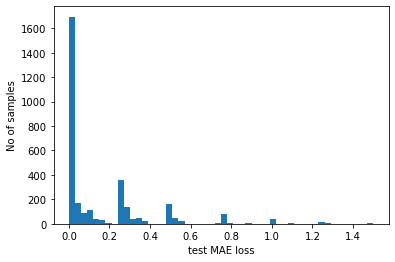

In [253]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [254]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  85
Indices of anomaly samples:  (array([  93,   94,  185,  186,  189,  190,  193,  194,  197,  198,  570,
        573,  574,  577,  578,  581,  582,  666,  669,  670,  761,  762,
        765,  766,  773,  774,  861,  862, 1316, 1328, 1329, 1330, 1334,
       1341, 1342, 1349, 1350, 1433, 1434, 1437, 1438, 1577, 1578, 1597,
       1598, 1625, 1626, 1629, 1630, 2193, 2194, 2205, 2206, 2297, 2298,
       2301, 2302, 2629, 2630, 2633, 2634, 2641, 2642, 2673, 2674, 2681,
       2682, 2685, 2686, 2769, 2770, 2777, 2778, 2781, 2782, 2789, 2790,
       2865, 2866, 2873, 2874, 2877, 2878, 3053, 3054], dtype=int64),)


In [255]:
anomalous_data_indices = []
for idx in range(TIME_STEPS - 1, len(df) - TIME_STEPS + 1):
    if np.all(anomalies[idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [261]:
df_anomalies = df.iloc[pd.Series(anomalous_data_indices).unique()]

In [262]:
df_anomalies

,SrcUnique,DstUnique,Authentications,Failures
2136,0,0,0,0
